# Age and Gender Prediction

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jangedoo/utkface-new
! unzip /content/utkface-new.zip

In [ ]:
! pip install lime
! pip install lightning

## Imports

In [ ]:
import os
import random
from collections import Counter
from typing import Optional, Tuple, Any, Callable, Union, Dict

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.module import Module
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import transforms, models
import torchvision.transforms.functional as TF

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lightning import Trainer
from lightning import LightningModule
from lightning import LightningDataModule
from lightning.pytorch.callbacks import EarlyStopping

import lime
from lime import lime_image

from PIL import Image
from sklearn.metrics import mean_absolute_error, accuracy_score
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from skimage.segmentation import mark_boundaries

## EDA

In [ ]:
def find_duplicate_files(dir1, dir2):
    files_set1 = set(os.listdir(dir1))
    files_set2 = set(os.listdir(dir2))

    duplicate_files = files_set1.intersection(files_set2)
    unique_files_dir1 = files_set1 - files_set2
    unique_files_dir2 = files_set2 - files_set1

    return list(duplicate_files), list(unique_files_dir1), list(unique_files_dir2)

directory1 = '/content/UTKFace'
directory2 = '/content/crop_part1'

duplicates, unique_dir1, unique_dir2 = find_duplicate_files(directory1, directory2)

if duplicates:
    print("Duplicate files found:")
    print(len(duplicates))
else:
    print("No duplicate files found.")

print("\nUnique files in Directory 1:")
print(len(unique_dir1))

print("\nUnique files in Directory 2:")
print(len(unique_dir2))

Duplicate files found:
9779

Unique files in Directory 1:
13929

Unique files in Directory 2:
1


In [ ]:
data_dir = '/content/UTKFace'
images = [img for img in os.listdir(
    data_dir) if img.endswith('.jpg') and img.count('_') == 3]

data = {
    'Image': images,
    'Age': [int(img.split('_')[0]) for img in images],
    'Gender': [int(img.split('_')[1]) for img in images],
    'Race': [int(img.split('_')[2]) for img in images],
    'DateTime': [img.split('_')[3].split('.')[0] for img in images]
}
df = pd.DataFrame(data)

In [ ]:
summary_stats = df.describe()
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
                Age        Gender          Race
count  23705.000000  23705.000000  23705.000000
mean      33.300907      0.477283      1.269226
std       19.885708      0.499494      1.345638
min        1.000000      0.000000      0.000000
25%       23.000000      0.000000      0.000000
50%       29.000000      0.000000      1.000000
75%       45.000000      1.000000      2.000000
max      116.000000      1.000000      4.000000


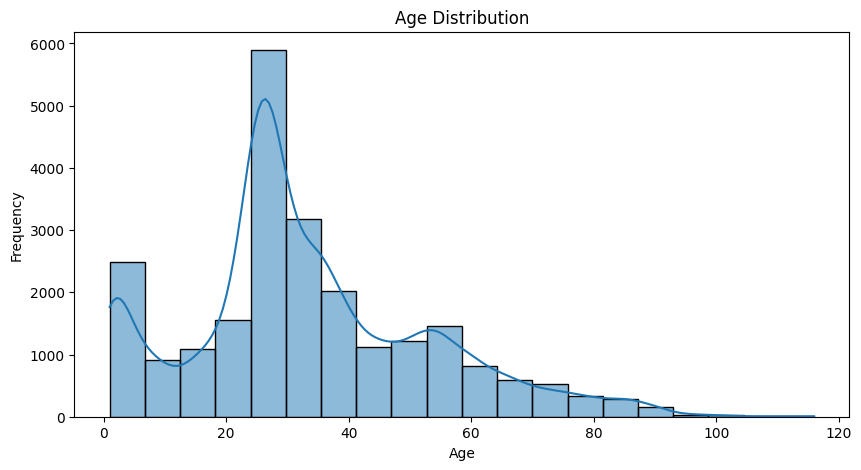

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Looking at the above age distribution plot we can see that we have smaller number od samples for higher age groups.

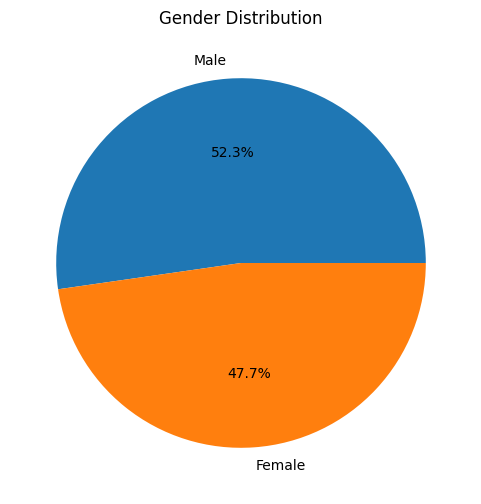

In [ ]:
gender_counts = df['Gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=['Male', 'Female'], autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

Here we can see that the two genders are almost closely distributed.

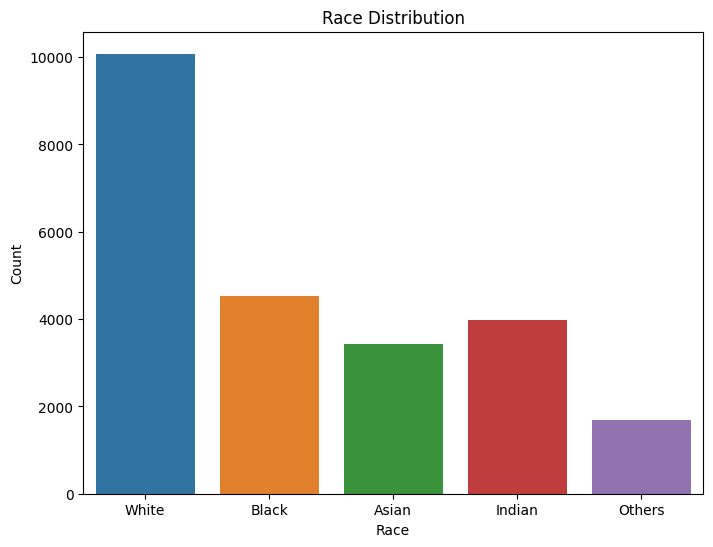

In [ ]:
race_labels = ['White', 'Black', 'Asian', 'Indian', 'Others']
race_counts = df['Race'].value_counts().reindex(range(5), fill_value=0)
plt.figure(figsize=(8, 6))
sns.barplot(x=race_labels, y=race_counts)
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Race Distribution')
plt.show()

Eventhough we don't use this in our models we can see the distribution of races in the data.

<ipython-input-10-9371e7e52a8c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


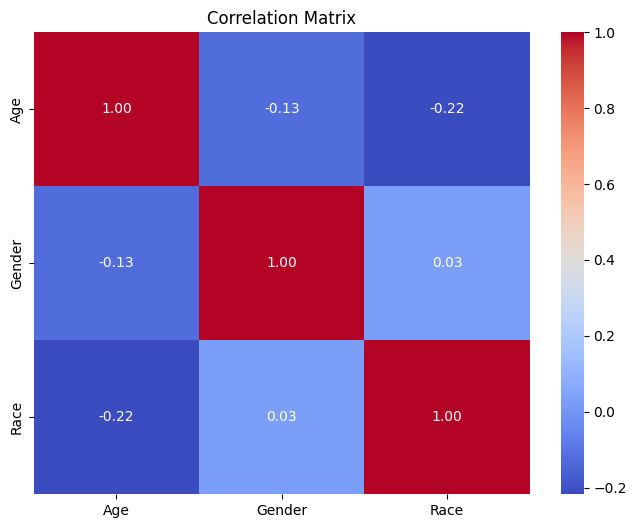

In [ ]:
plt.figure(figsize=(8, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

As we can see above we don't really see a strong correlation between neither of the categories.

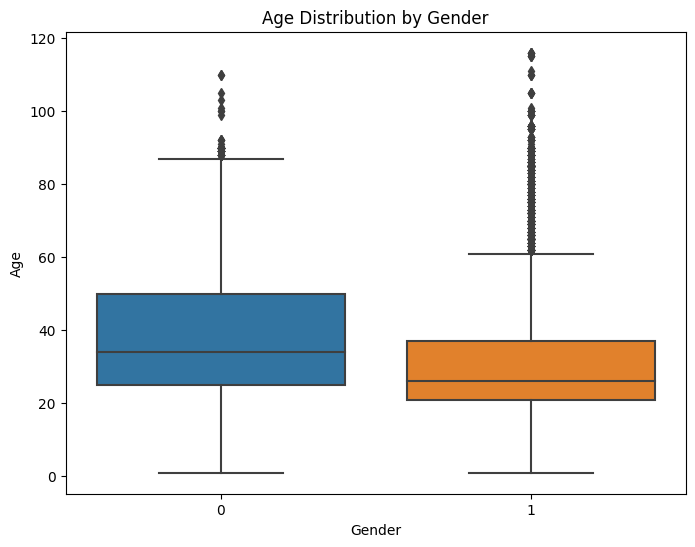

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Gender', y='Age', data=df)
plt.title('Age Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

The distribution of ages among males (0) shows fewer outliers compared to females (1). Additionally, the female category exhibits a higher proportion of younger examples compared to older ones, whereas the male category shows a more balanced distribution across age groups.

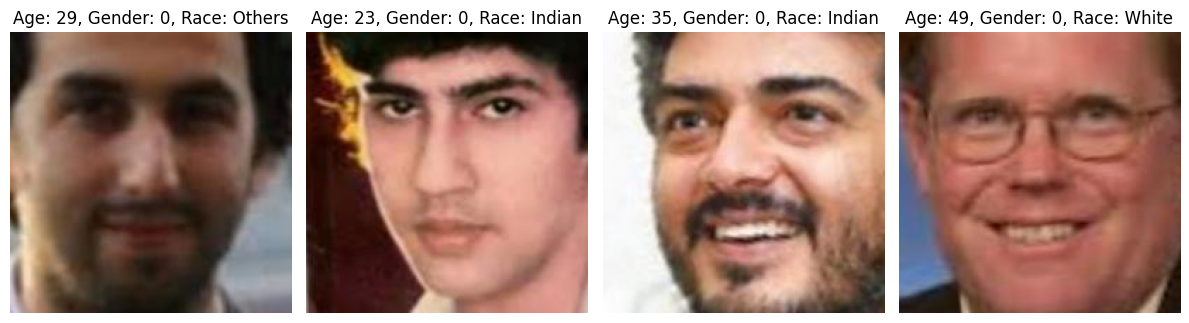

In [ ]:
num_samples_to_display = 4
sample_images = df.sample(num_samples_to_display)['Image'].tolist()
plt.figure(figsize=(12, 8))
for i, image_name in enumerate(sample_images):
    img_path = os.path.join(data_dir, image_name)
    image = Image.open(img_path)
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(image)
    plt.title(f'Age: {df.loc[df["Image"] == image_name, "Age"].values[0]}, '
              f'Gender: {df.loc[df["Image"] == image_name, "Gender"].values[0]}, '
              f'Race: {race_labels[df.loc[df["Image"] == image_name, "Race"].values[0]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

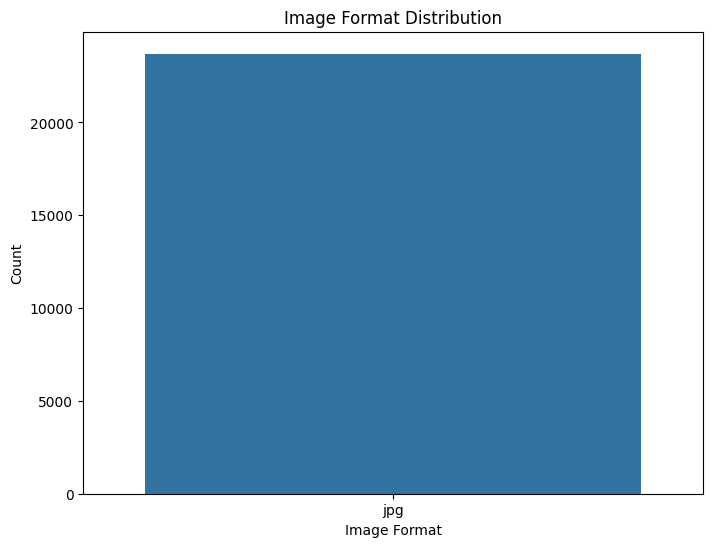

In [ ]:
image_formats = [img.split('.')[-1] for img in images]
format_counts = Counter(image_formats)

plt.figure(figsize=(8, 6))
sns.barplot(x=list(format_counts.keys()), y=list(format_counts.values()))
plt.title('Image Format Distribution')
plt.xlabel('Image Format')
plt.ylabel('Count')
plt.show()

We only have .jpg image format in our data

In [ ]:
total_width, total_height = 0, 0
num_images = len(images)

for img_name in images:
    img_path = os.path.join(data_dir, img_name)
    image = Image.open(img_path)
    width, height = image.size
    total_width += width
    total_height += height

average_width = total_width / num_images
average_height = total_height / num_images

print(f"Average width of images: {average_width}")
print(f"Average height of images: {average_height}")

Average width of images: 200.0
Average height of images: 200.0


We can see the average width and height of images in the data is actually 200

## Modelling

In [ ]:
class UTKFaceDataset(Dataset):
    """
    Dataset class for UTKFace dataset.

    Args:
    - root_dir (str): Root directory path containing the dataset.
    - transform (Optional[Callable]): A function/transform to apply to the images.

    Attributes:
    - root_dir (str): Root directory path containing the dataset.
    - transform (Optional[Callable]): A function/transform to apply to the images.
    - images (List[str]): List of filtered image names.

    Methods:
    - _filter_dataset: Filters the dataset to include only images with gender labels 0 or 1.
    - __len__: Returns the total number of images in the dataset.
    - __getitem__: Gets an image and its associated age and gender label at the specified index.
    """
    def __init__(self, root_dir: str, transform: Optional[Callable] = None) -> None:
        self.root_dir: str = root_dir
        self.transform: Optional[Callable] = transform
        self.images: List[str] = self._filter_dataset()

    def _filter_dataset(self) -> List[str]:
        """
        Filters the dataset to include only images with gender labels 0 or 1.

        Returns:
        - filtered_images (List[str]): List of filtered image names.
        """
        images: List[str] = os.listdir(self.root_dir)
        filtered_images: List[str] = []

        for img_name in images:
            filename: str = img_name.split('.jpg')[0]
            parts: List[str] = filename.split('_')
            gender: int = int(parts[1])

            if gender in [0, 1]:
                filtered_images.append(img_name)

        return filtered_images

    def __len__(self) -> int:
        """
        Returns the total number of images in the dataset.

        Returns:
        - length (int): Total number of images in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[Any, float, int]:
        """
        Gets an image and its associated age and gender label at the specified index.

        Args:
        - idx (int): Index of the image to retrieve.

        Returns:
        - Tuple containing image, age, and gender label.
        - image (Any): Image data.
        - age (float): Age associated with the image.
        - gender (int): Gender label (0 or 1) associated with the image.
        """
        img_name: str = os.path.join(self.root_dir, self.images[idx])
        image: Any = cv2.imread(img_name)

        if self.transform:
            image = self.transform(image)

        filename: str = self.images[idx].split('.jpg')[0]
        parts: List[str] = filename.split('_')
        age: float = float(parts[0])
        gender: int = int(parts[1])

        return image, age, gender

The above class grabs one sample from the given batch and returns the image with its associated label.

In [ ]:
class UTKFaceDataModule(LightningDataModule):
    """
    Lightning DataModule for UTKFace dataset.

    Args:
    - root_dir (str): Root directory path containing the dataset.
    - transform (Optional[Callable]): A function/transform to apply to the images.
    - batch_size (int): Batch size for data loaders (default: 32).

    Attributes:
    - root_dir (str): Root directory path containing the dataset.
    - transform (Optional[Callable]): A function/transform to apply to the images.
    - batch_size (int): Batch size for data loaders.
    - dataset (UTKFaceDataset): UTKFaceDataset object.

    Methods:
    - setup: Set up train, validation, and test datasets.
    - train_dataloader: Returns a DataLoader for the training dataset.
    - val_dataloader: Returns a DataLoader for the validation dataset.
    - test_dataloader: Returns a DataLoader for the test dataset.
    - get_random_test_image: Returns a random image from the test dataset.
    """
    def __init__(self, root_dir: str, transform: Optional[Callable] = None, batch_size: int = 32) -> None:
        super().__init__()
        self.root_dir: str = root_dir
        self.transform: Optional[Callable] = transform
        self.batch_size: int = batch_size
        self.dataset: Optional[UTKFaceDataset] = None

    def setup(self, stage: Optional[str] = None) -> None:
        """
        Set up train, validation, and test datasets.

        Args:
        - stage (Optional[str]): Stage of training (default: None).
        """
        self.dataset = UTKFaceDataset(self.root_dir, self.transform)
        train_length: int = int(len(self.dataset) * 0.7)
        val_length: int = int(len(self.dataset) * 0.1)
        test_length: int = len(self.dataset) - train_length - val_length
        generator1: torch.Generator = torch.Generator().manual_seed(42)
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            self.dataset, [train_length, val_length, test_length], generator=generator1)

    def train_dataloader(self) -> DataLoader:
        """
        Returns a DataLoader for the training dataset.

        Returns:
        - DataLoader: DataLoader for the training dataset.
        """
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self) -> DataLoader:
        """
        Returns a DataLoader for the validation dataset.

        Returns:
        - DataLoader: DataLoader for the validation dataset.
        """
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=2)

    def test_dataloader(self) -> DataLoader:
        """
        Returns a DataLoader for the test dataset.

        Returns:
        - DataLoader: DataLoader for the test dataset.
        """
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=2)

    def get_random_test_image(self) -> Any:
        """
        Returns a random image from the test dataset.

        Returns:
        - Any: Random image from the test dataset.
        """
        random_idx: int = random.randint(0, len(self.test_dataset) - 1)
        image, _, _ = self.test_dataset[random_idx]
        return image

The above class splits the data into its respective train, test, and validation splits and returns the data loaders for the splits.

In [ ]:
class MultiOutputModel(LightningModule):
    """
    PyTorch Lightning Module for a multi-output model predicting age and gender.

    Args:
    - model (Any): The base neural network model.
    - dimension (int): Dimension size (default: 512).
    - class_weights (Optional[torch.Tensor]): Weights for different classes in gender prediction.
    - lr (float): Learning rate for optimizer (default: 0.001).
    - weight_decay (Optional[float]): Weight decay for optimizer (default: None).

    Attributes:
    - model (Any): The base neural network model.
    - dimension (int): Dimension size.
    - lr (float): Learning rate for optimizer.
    - weight_decay (Optional[float]): Weight decay for optimizer.
    - base_model (nn.Sequential): Sequential layer of the base model excluding the last layer.
    - age_branch (nn.Linear): Linear layer for age prediction.
    - gender_branch (nn.Linear): Linear layer for gender prediction.

    Methods:
    - forward: Forward pass through the model.
    - training_step: Defines the training step.
    - validation_step: Defines the validation step.
    - configure_optimizers: Configures the optimizer and scheduler.
    """
    def __init__(
        self,
        model: Any,
        dimension: int = 512,
        lr: float = 0.001,
        weight_decay: Optional[float] = None
    ) -> None:
        super().__init__()
        self.model = model
        self.dimension = dimension
        self.lr = lr
        self.weight_decay = weight_decay
        self.base_model = nn.Sequential(*list(self.model.children())[:-1])
        self.age_branch = nn.Linear(self.dimension, 1)
        self.gender_branch = nn.Linear(self.dimension, 2)
        self.save_hyperparameters(ignore=['model'])

    def forward(self, inputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the model.

        Args:
        - inputs (torch.Tensor): Input tensor.

        Returns:
        - Tuple containing predicted age and gender.
        """
        x = self.base_model(inputs)
        x = x.view(x.size(0), -1)
        age = self.age_branch(x)
        gender = self.gender_branch(x)
        return age, gender

    def training_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int
    ) -> torch.Tensor:
        """
        Defines the training step.

        Args:
        - batch (Tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
          Input batch containing images, ages, and genders.
        - batch_idx (int): Index of the batch.

        Returns:
        - torch.Tensor: Loss tensor for the training step.
        """
        images, ages, genders = batch
        unique_values = torch.unique(genders)
        age_preds, gender_preds = self(images)
        age_preds = age_preds.view(-1).float()
        age_loss = F.l1_loss(age_preds, ages.float())

        gender_loss = F.cross_entropy(gender_preds, genders.long())
        loss = age_loss + gender_loss
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int
    ) -> None:
        """
        Defines the validation step.

        Args:
        - batch (Tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
          Input batch containing images, ages, and genders.
        - batch_idx (int): Index of the batch.
        """
        images, ages, genders = batch
        age_preds, gender_preds = self(images)
        age_preds = age_preds.view(-1).float()
        age_loss = F.l1_loss(age_preds, ages.float())
        gender_loss = F.cross_entropy(gender_preds, genders.long())

        age_mae = mean_absolute_error(
            ages.cpu().numpy(), age_preds.detach().cpu().numpy())
        gender_acc = accuracy_score(
            genders.cpu().numpy(), gender_preds.argmax(dim=1).cpu().numpy())

        loss = age_loss + gender_loss
        self.log('val_loss', loss)
        self.log('val_age_mae', age_mae)
        self.log('val_gender_acc', gender_acc)

    def configure_optimizers(self) -> Tuple[Any, Any]:
        """
        Configures the optimizer and scheduler.

        Returns:
        - Tuple containing optimizer and scheduler.
        """
        if self.weight_decay is None:
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        else:
            optimizer = torch.optim.AdamW(
                self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2)
        return [optimizer], [{'scheduler': scheduler, 'monitor': 'val_loss'}]

The above class is our model class which handles much of the logic for modelling.

First of all we have a set of parameters for the class:
- model: which is the base model we will be using for transfer learning
- dimension: This paramater is here because when we use diffrent models for training diffrent models require different dimensions to work so it is there so that we can easily configure that.
- lr: this is here to set the Learning rate for optimizer.
- weight_decay: is here to add regularization to the model when needed.

Then the forward method Passes the input through the base model and Processes the output through layers to predict age and gender.

The training step method then Computes predictions for age and gender, Calculates losses for age and gender predictions, Logs the training loss for visualization and tracking.

The validation step method Computes predictions for age and gender, Calculates losses for age and gender predictions, Computes evaluation metrics such as mean absolute error for age and accuracy for gender, Logs validation loss and evaluation metrics for analysis.

Finally the configure optimizers Sets up the optimizer (AdamW) with or without weight decay and Configures a scheduler (ReduceLROnPlateau) to adjust the learning rate during training based on validation loss.

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

I have also added an additional early stopping callback so that the model stops training if the validation loss is not decreasing after 2 successive epochs.

In [ ]:
resnet18_model = MultiOutputModel(models.resnet18(weights=models.ResNet18_Weights.DEFAULT))
datamodule = UTKFaceDataModule(root_dir="/content/UTKFace", transform=transforms.ToTensor())
trainer = Trainer(max_epochs=15, callbacks=[early_stopping_callback])
trainer.fit(resnet18_model, datamodule=datamodule)

First the model was trained on the ResNet 18 weights.

In [ ]:
def get_latest_log_dir(base_dir: str ='./lightning_logs'):
    """
    Get the latest log directory based on version number

    Args:
        base_dir: Base directory containing log folders

    Returns:
        Latest log directory path
    """
    log_dirs = [d for d in os.listdir(base_dir) if d.startswith('version_')]
    log_dirs.sort(key=lambda x: int(x.split('_')[-1]))
    latest_log_dir = os.path.join(base_dir, log_dirs[-1]) if log_dirs else None

    return latest_log_dir

In [ ]:
def get_all_logs(log_dir: str):
    """
    Get all logs from tensorboard

    Args:
        log_dir: log directory

    Returns:
        Logs
    """
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    tags = event_acc.Tags()['scalars']

    logs = {}
    for tag in tags:
        logs[tag] = [s.value for s in event_acc.Scalars(tag)]

    return logs
log_dir = get_latest_log_dir()
all = get_all_logs(log_dir)

In [ ]:
def plot_losses(all: Dict[str, np.ndarray]) -> None:
    """
    Plot training and validation losses, age mean absolute error, and gender accuracy.

    Args:
    - all (Dict[str, np.ndarray]): Dictionary containing loss and metric values.

    This function plots:
    - Training and validation losses over epochs.
    - Validation age mean absolute error and gender accuracy over epochs.
    - Prints the mean values of age mean absolute error and gender accuracy.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(all['train_loss_epoch'], label='Train Loss')
    plt.plot(all['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(all['val_age_mae'], label='Validation Age Mean Absolute Error')
    plt.plot(all['val_gender_acc'], label='Validation Gender Accuracy')
    plt.title('Metrics over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.show()

    mean_mae = np.mean(all['val_age_mae'])
    mean_accuracy = np.mean(all['val_gender_acc'])
    print(f'Mean MAE(Age): {mean_mae} - Mean Accuracy(Gender): {mean_accuracy}')

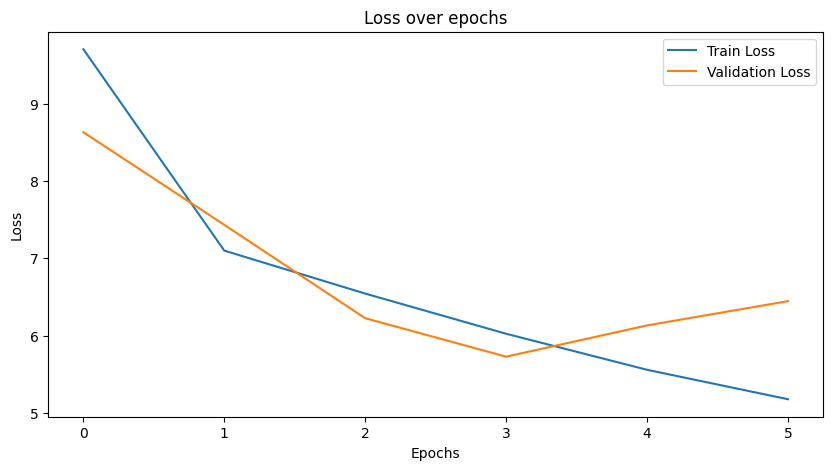

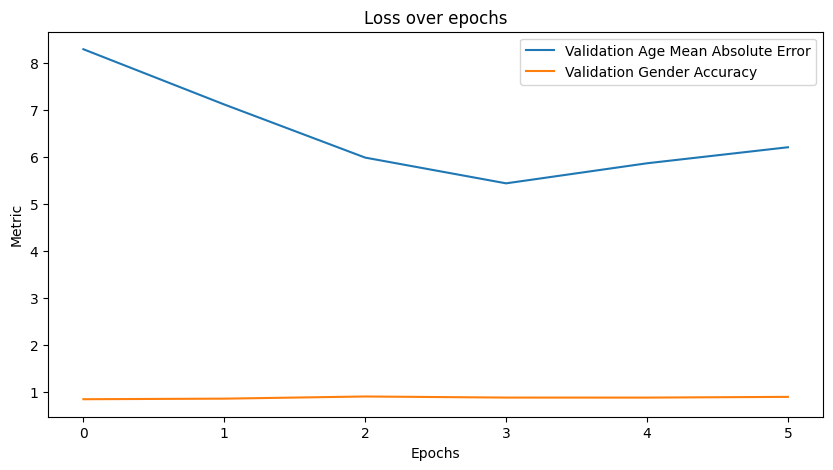

Mean MAE(Age): 6.486945549647014 - Mean Accuracy(Gender): 0.8688466946283976


In [ ]:
plot_losses(all)

Looking at the first plot for train and validation losses the model has trained for 6 epochs and stopped training after that because val loss wasnot decreasing for two successive epochs.

Looking at the 2nd plot we can see that the mean absolute error has been decreasing intially but later on started to increase, while the accuracy was for the most part steady.

We have got 6.49 MAE and 0.868 accuracy.

In [ ]:
test_dataloader = datamodule.test_dataloader()

def tester(test_dataloader: DataLoader, model: Module) -> None:
    """
    Test the trained model on the test dataset and display predictions for random samples.

    Args:
    - test_dataloader (DataLoader): DataLoader for the test dataset.
    - model (Module): Trained PyTorch model for inference.

    This function iterates through the test dataloader, predicts ages and genders using the model,
    displays a random sample's image with true and predicted age/gender labels, and breaks after one iteration.
    """
    for batch in test_dataloader:
        idx = random.randint(0, len(batch[0]) - 1)

        image = batch[0][idx].unsqueeze(0)
        age_label = batch[1][idx]
        gender_label = batch[2][idx]

        age_pred, gender_pred = model(image)

        age_pred = round(age_pred.item())
        gender_pred = torch.argmax(gender_pred, dim=1).item()

        image_np = TF.to_pil_image(image.squeeze(0))
        plt.imshow(image_np)
        plt.axis('off')
        plt.title(f"True Age: {age_label}, Predicted Age: {age_pred}\nTrue Gender: {gender_label}, Predicted Gender: {gender_pred}")
        plt.show()
        break

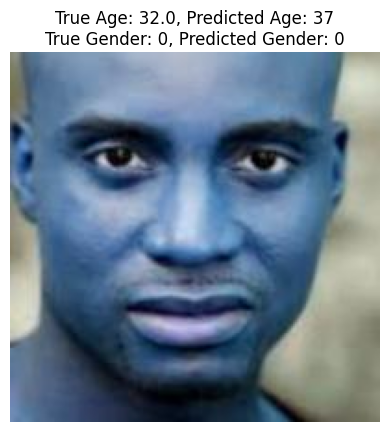

In [ ]:
tester(test_dataloader, resnet18_model)

In [ ]:
def lime_explainer(model):
    """
    Explain the model's predictions using LIME (Local Interpretable Model-agnostic Explanations).

    Args:
    - model: Trained PyTorch model.

    This function:
    - Sets the model to evaluation mode.
    - Defines a prediction function for LIME to generate explanations.
    - Uses LIME to explain the model's prediction on a random test image.
    - Displays the original image alongside the explanation mask.
    """
    model.eval()

    def predict(input):
        input = torch.stack([transforms.ToTensor()(i) for i in input])
        input = input.to(next(model.parameters()))

        age, gender = model(input)

        probs = torch.nn.functional.softmax(gender, dim=1).cpu().detach().numpy()
        return probs

    explainer = lime_image.LimeImageExplainer()

    random_test_image = datamodule.get_random_test_image()

    random_test_image = np.transpose(random_test_image.numpy(), (1, 2, 0))

    explanation = explainer.explain_instance(random_test_image,
                                             predict,
                                             top_labels=5,
                                             hide_color=0,
                                             num_samples=1000)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=10,
                                                hide_rest=False)

    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

  0%|          | 0/1000 [00:00<?, ?it/s]

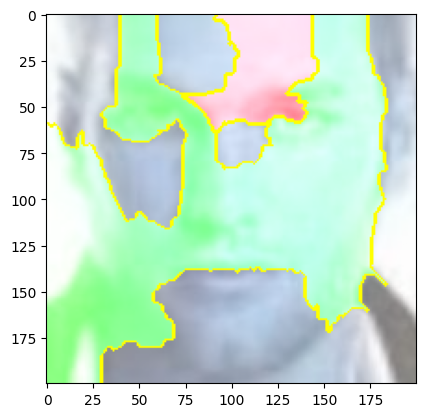

In [ ]:
lime_explainer(resnet18_model)

Here LIME ahows us which parts of the image were significnat for the prediction. The colored regions are indicators of that.

In [ ]:
resnet50_model = MultiOutputModel(models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
                                  dimension=2048)
datamodule = UTKFaceDataModule(root_dir="/content/UTKFace", transform=transforms.ToTensor())
trainer_rs50 = Trainer(max_epochs=15, callbacks=[early_stopping_callback])
trainer_rs50.fit(resnet50_model, datamodule=datamodule)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type       | Params
---------------------------------------------
0 | model         | ResNet     | 25.6 M
1 | base_model    | Sequential | 23.5 M
2 | age_branch    | Linear     | 2.0 K 
3 | gender_branch | Linear     | 4.1 K 
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Then I used a model with more parameters the ResNet 50.

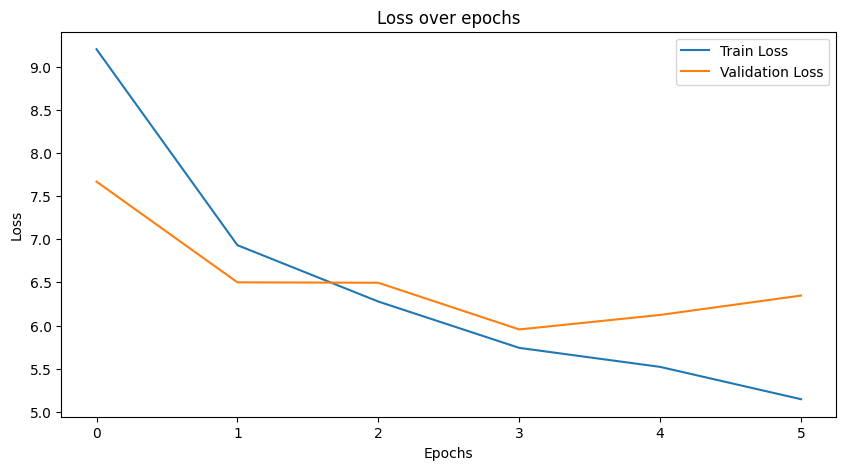

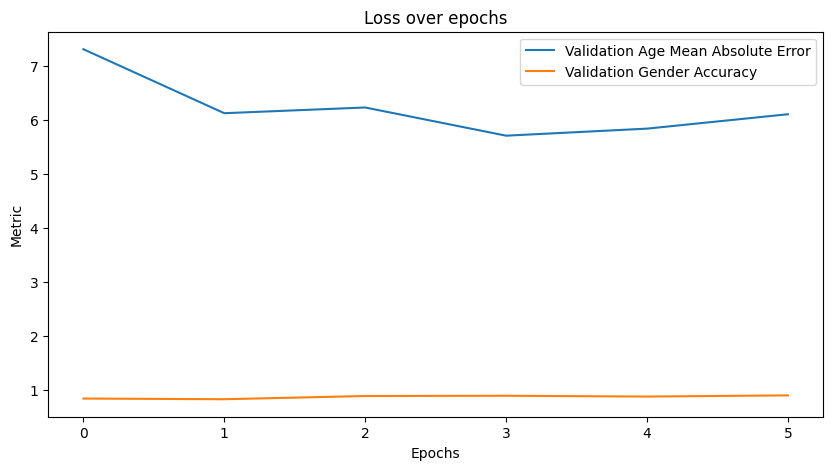

Mean MAE(Age): 6.225001970926921 - Mean Accuracy(Gender): 0.8685654004414877


In [ ]:
log_dir = get_latest_log_dir()
all = get_all_logs(log_dir)
plot_losses(all)

Here again the model has trained for 6 epochs and the validation loss seems to be jumping around a lot.

The MAE is also fluctuating as well.

Now we have a 6.22 MAE (Slightly better than the previous) and 0.868 acuracy.

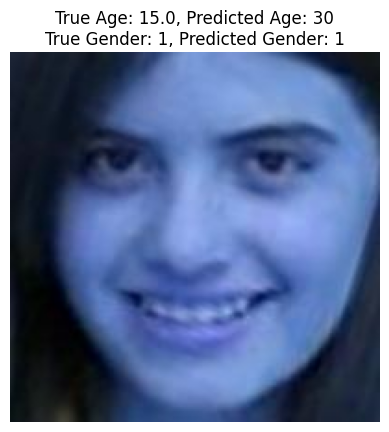

In [ ]:
tester(test_dataloader, resnet50_model)

  0%|          | 0/1000 [00:00<?, ?it/s]

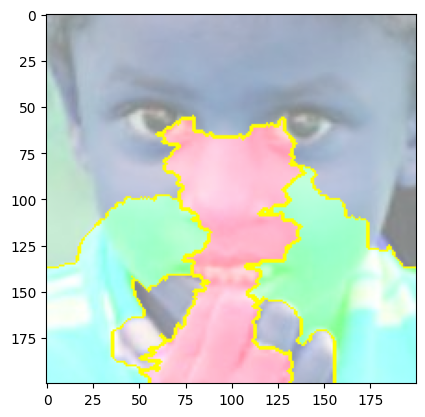

In [ ]:
lime_explainer(resnet50_model)

In [ ]:
resnet50_wd_model = MultiOutputModel(models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
                                     dimension=2048,
                                     weight_decay=1e-5)
datamodule = UTKFaceDataModule(root_dir="/content/UTKFace", transform=transforms.ToTensor())
trainer_rs50_wd = Trainer(max_epochs=15, callbacks=[early_stopping_callback])
trainer_rs50_wd.fit(resnet50_wd_model, datamodule=datamodule)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type       | Params
---------------------------------------------
0 | model         | ResNet     | 25.6 M
1 | base_model    | Sequential | 23.5 M
2 | age_branch    | Linear     | 2.0 K 
3 | gender_branch | Linear     | 4.1 K 
---------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    To

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Then I used the same ResNet 50 model but with some weight decay for regularization.

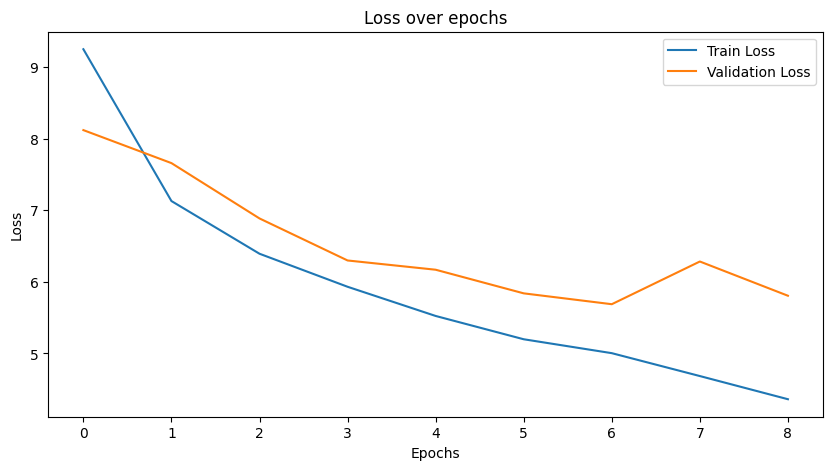

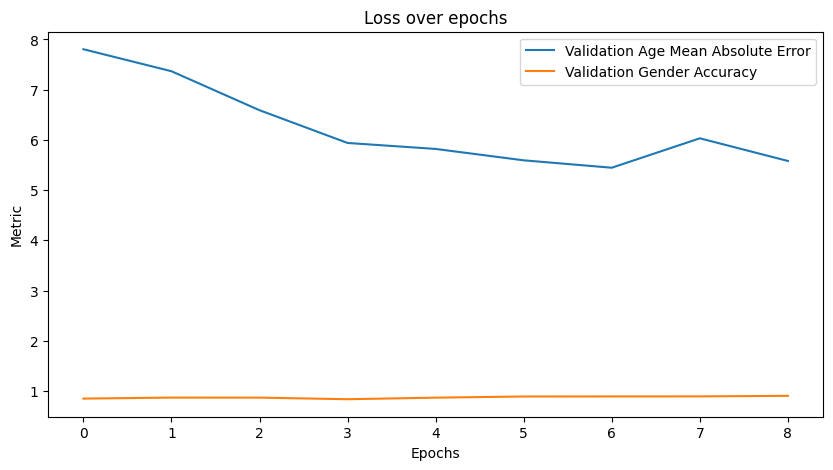

Mean MAE(Age): 6.242084768083361 - Mean Accuracy(Gender): 0.8743084934022691


In [ ]:
log_dir = get_latest_log_dir()
all = get_all_logs(log_dir)
plot_losses(all)

As we can see above the regularization has helped us achieve prolonged training epochs as we can see this model trained for 9 epochs.

The model was performing good for the initial epochs and we see some fluctuations at the end.

We have got a 6.242 for the MAE(Slightly higher than the previous) and 0.874 for the accuracy which is better than the above 2 models.

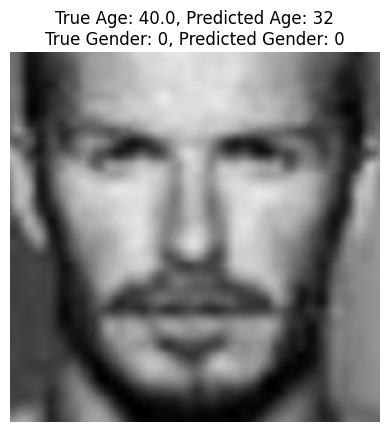

In [ ]:
tester(test_dataloader, resnet50_wd_model)

  0%|          | 0/1000 [00:00<?, ?it/s]

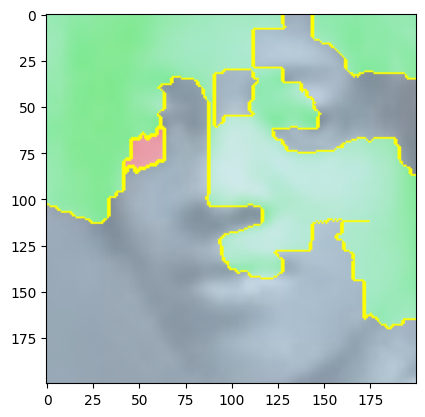

In [ ]:
lime_explainer(resnet50_wd_model)

## Ethical Issues with the Model

This models I built can be biased in many ways. The model might make a mistake predicting the gender of an individual or give a very wrong estimate of age prediction.

In the results of the model the gender prediction seems to be good for the most part it rarely misses the gender of the person but the greatest bias I see is in the age prediction. For samples where age is very small or very high it most of the time doesn't even predict the age properly, not even a close guess is given.

For mitigating this challenges we can implement:
- Fairness: Ensure the model's predictions are fair and unbiased across different demographics. Mitigation strategies could involve using diverse and representative datasets and applying fairness-aware learning techniques.

- Transparency: The model's decisions should be explainable and transparent. Employ interpretability techniques to understand how the model arrives at its predictions, aiding in addressing biases and ensuring accountability.

- Diverse Representation: Ensure diverse perspectives and expert input when developing and validating the model to mitigate biases from specific viewpoints.

This model can be used in Marketing and Advertising, Companies might use such models for targeted advertising based on demographic information inferred from pictures and also in Content Personalization, Streaming platforms and content providers could use it to personalize content recommendations.

This model cannot be deployed in scenarios where users haven't consented on giving out thier private information, for law enforcement and surveillace systems or in areas where sensitive decision making is required.

## Summary

In this project, I constructed several models aimed at predicting the age and gender of individuals using images sourced from the UTKFace dataset. I delved into examining the dataset's contents, the interplay between variables, and the diverse file types present. It emerged that the dataset exhibited balanced gender samples, whereas the age distribution was skewed.

Following this, I trained three models: one based on the ResNet18 architecture and the remaining two utilizing the ResNet50 model. The performance attained by these models serves as a promising initial benchmark. Subsequent analysis of the models revealed that while our approach demonstrated satisfactory gender prediction, it fell short in accurately predicting age.

Moreover, I employed LIME for model interpretability, uncovering insights into which image components the model emphasized for making predictions.

## Future Work

In order to improve the performance of the models I developed, future enhancements could involve augmenting the dataset with more balanced samples for age groups that are currently underrepresented. Additionally, leveraging more robust and high-performing models pretrained on larger datasets can significantly enhance the model's capabilities.